## FACE MORPHING

In [57]:
import os, cv2, sys, math, random
import numpy as np
from numpy.linalg import svd, inv
from matplotlib import pyplot as plt

%matplotlib inline

lines_color = (255,255, 0)
points_color = (255, 0, 0)

In [58]:
folder_name = ''
file_paths = []
file_names = []

# Iterate through the images in the 'inputs' folder
for filename in os.listdir('inputs'):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        file_names.append(os.path.splitext(filename)[0])
        file_paths.append(os.path.join('inputs', filename))
        folder_name += os.path.splitext(filename)[0] + '_'

# Remove the trailing underscore from folder_name
folder_name = folder_name.rstrip('_')
folder_path = os.path.join("./outputs", folder_name)

# Create the new folder
os.makedirs(folder_path, exist_ok=True)

os.makedirs("./frames", exist_ok=True)
os.makedirs("./inputs", exist_ok=True)
os.makedirs("./outputs", exist_ok=True)
os.makedirs("./temp", exist_ok=True)

# Output the folder name and file paths
print("Folder Name:", folder_name)
print("File Paths:", file_paths)
print("File Name:", file_names)

Folder Name: CaptainAmerica_IronMan_BlackWidow
File Paths: ['inputs/CaptainAmerica.jpg', 'inputs/IronMan.jpg', 'inputs/BlackWidow.jpg']
File Name: ['CaptainAmerica', 'IronMan', 'BlackWidow']


In [59]:
def convertImages2mpeg(input_path, output_path, fps):
    dir_frames = input_path
    files_info = os.scandir(dir_frames)

    file_names = [f.path for f in files_info if f.name.endswith(".jpg")]
    file_names.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    frame_Height, frame_Width = cv2.imread(file_names[0]).shape[:2]
    resolution = (frame_Width, frame_Height)

    fourcc = cv2.VideoWriter_fourcc(*'MPG1')
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, resolution)

    frame_count = len(file_names)

    frame_idx = 0

    while frame_idx < frame_count:

        frame_i = cv2.imread(file_names[frame_idx])
        video_writer.write(frame_i)
        frame_idx += 1

    video_writer.release()

In [60]:
def readPoints(path):
    pts = []
    with open(path) as file:
        for line in file:
            x, y = line.split()
            pts.append((int(x), int(y)))
    
    return pts

In [61]:
# Write points to a text file
def writePoints(obj, size, coords):
    pts = []
    xw = [int(i) for i in coords[0]]
    yw = [int(i) for i in coords[1]]
    for p in range(len(coords[0])):
        pts.append((xw[p], yw[p]))
    
    # Add corners          
    pts.append((0, 0))
    pts.append((0, size[0]-1))
    pts.append((size[1]-1, 0))
    pts.append((size[1]-1, size[0]-1))
        
    path = 'temp/' + obj + '_pts.txt'
    f = open(path, 'w')
    for p in pts:
        f.write(' '.join(str(s) for s in p) + '\n')
    f.close()
    
    return path

In [62]:
# Write triangles to a text file
def writeTriangles(obj, coords, pts):
    tri = []
    for t in coords: 
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        tri.append((pts.index(pt1), pts.index(pt2), pts.index(pt3)))

    path = 'temp/' + obj + '_tri.txt'
    f=open(path, 'w')
    for t in tri:
        f.write(' '.join(str(s) for s in t) + '\n')
    f.close()
    
    return path

In [63]:
# Check if a point is inside a rectangle
def insideRectangle(rect, point):
    if point[0] < rect[0]:
        return False
    elif point[1] < rect[1]:
        return False
    elif point[0] > rect[2]:
        return False
    elif point[1] > rect[3]:
        return False
    
    return True

In [64]:
# Draw a Delaunay triangles
def drawDelaunay(img, rect, subdiv, color):  
    triList = subdiv.getTriangleList()
    for t in triList: 
        pt1 = (int(t[0]), int(t[1]))
        pt2 = (int(t[2]), int(t[3]))
        pt3 = (int(t[4]), int(t[5]))
        
        if insideRectangle(rect, pt1) and insideRectangle(rect, pt2) and insideRectangle(rect, pt3):
            cv2.line(img, pt1, pt2, color, 2, cv2.LINE_AA, 0)
            cv2.line(img, pt2, pt3, color, 2, cv2.LINE_AA, 0)
            cv2.line(img, pt3, pt1, color, 2, cv2.LINE_AA, 0)
    
    return triList

In [65]:
# Get Triangles from image
def getTriangles(obj, img, coords):
    # Save points to text file then read them back
    size = img.shape
    ptsPath = writePoints(obj, size, coords)
    points = readPoints(ptsPath)

    # Create an instance of Subdiv2D
    rect = (0, 0, size[1], size[0])
    subdiv = cv2.Subdiv2D(rect)

    # Insert points into subdiv
    for p in points:
        subdiv.insert(p)
    
    # Draw delaunay triangles and points
    triList = drawDelaunay(img, rect, subdiv, lines_color)
    triPath = writeTriangles(obj, triList, points)

    for p in points:
        cv2.circle(img, p, 4, points_color, cv2.FILLED, cv2.LINE_AA, 0)

    # Show results
    fig = plt.figure()
    fig.set_label('Delaunay Trianuglation')
    plt.axis('off')
    plt.imshow(img);
    fig.savefig(os.path.join(folder_path, str(obj) + '.png'))
    
    return ptsPath, triPath

In [66]:
# Warps and blends triangular regions from img1 and img2 to img
def morphTriangle(alpha, img1, img2, img, t1, t2, ta):
    (x1, y1, w1, h1) = cv2.boundingRect(np.float32([t1]))
    (x2, y2, w2, h2) = cv2.boundingRect(np.float32([t2]))
    (xa, ya, wa, ha) = cv2.boundingRect(np.float32([ta]))
    
    t1Rect = []
    t2Rect = []
    taRect = []
    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - x1), (t1[i][1] - y1)))
        t2Rect.append(((t2[i][0] - x2), (t2[i][1] - y2)))
        taRect.append(((ta[i][0] - xa), (ta[i][1] - ya)))

    mask = np.zeros((ha, wa, 3), dtype=float)
    cv2.fillConvexPoly(mask, np.int32(taRect), (1.0, 1.0, 1.0), 16, 0);
    
    img1Rect = np.zeros((h1, w1, 3), dtype=float)
    for h in range(h1):
        for w in range(w1):
            img1Rect[h,w,:] = img1[y1+h,x1+w,:]   
    
    img2Rect = np.zeros((h2, w2, 3), dtype=float)
    for h in range(h2):
        for w in range(w2):
            img2Rect[h,w,:] = img2[y2+h,x2+w,:]
    
    warp1 = cv2.getAffineTransform(np.float32(t1Rect), np.float32(taRect))
    warpImage1 = cv2.warpAffine(img1Rect, warp1, (wa, ha), None, \
                                flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    
    warp2 = cv2.getAffineTransform(np.float32(t2Rect), np.float32(taRect))
    warpImage2 = cv2.warpAffine(img2Rect, warp2, (wa, ha), None, \
                                flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    
    imgRect = (1 - alpha) * warpImage1 + alpha * warpImage2

    for h in range(ha):
        for w in range(wa):
            img[ya+h,xa+w,:] = img[ya+h,xa+w,:] * (1 - mask[h,w,:]) + imgRect[h,w,:] * mask[h,w,:] 
        

In [67]:
def morphImage(alpha, tpath, img1, ppath1, img2, ppath2):
    pts1 = readPoints(ppath1)
    pts2 = readPoints(ppath2)

    aPts = []
    for i in range(len(pts1)):
        x = (1 - alpha) * pts1[i][0] + alpha * pts2[i][0]
        y = (1 - alpha) * pts1[i][1] + alpha * pts2[i][1]
        aPts.append((x, y))

    imgMorph = np.zeros(img1.shape)

    with open(tpath) as file:
        for line in file:
            x, y, z = (int(i) for i in line.split())
        
            t1 = [pts1[x], pts1[y], pts1[z]]
            t2 = [pts2[x], pts2[y], pts2[z]]
            ta = [aPts[x], aPts[y], aPts[z]]
            
            morphTriangle(alpha, img1, img2, imgMorph, t1, t2, ta)
    
    return imgMorph

In [68]:
import dlib

In [69]:
def detectLandmarks(img_file):
    face_detector = dlib.get_frontal_face_detector()
    face_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    img_origin_return = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB).astype('float') / 255.0
    img_origin = cv2.imread(img_file)
    img_test = img_origin.copy() 
    
    img_test_gray = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)

    faces_in_image = face_detector(img_test_gray, 0) 
    
    for face in faces_in_image:

        face_landmarks = face_predictor(img_test_gray, face)

        landmarks_list = []
        for i in range(0, face_landmarks.num_parts):
            landmarks_list.append((face_landmarks.part(i).x, face_landmarks.part(i).y))

        # write down the number for each landmark point
        for landmark_num, xy in enumerate(landmarks_list, start = 1):
            cv2.circle(img_test, (xy[0], xy[1]), 8, (0, 0, 0), -1)
            cv2.putText(img_test, str(landmark_num), (xy[0]-7, xy[1]+5), \
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)
    
    x_cord_list = []
    y_cord_list = []
    for pts_xy in landmarks_list:
        x_cord_list.append(pts_xy[0])
        y_cord_list.append(pts_xy[1])
            
    points_return = [x_cord_list, y_cord_list]   
    
    img_test= cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

    img_file_new = img_file.replace('inputs/', 'temp/')
    img_file_new = img_file_new.replace('.jpg', '.txt')

    f = open(img_file_new, 'w')
    for p in landmarks_list:
        f.write(' '.join(str(s) for s in p) + '\n')
    f.close()
    
    return img_origin_return, img_test, points_return

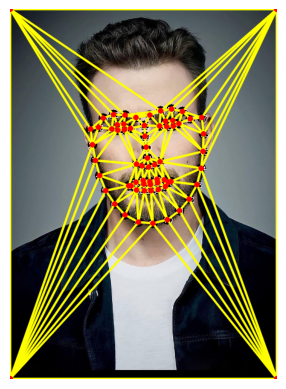

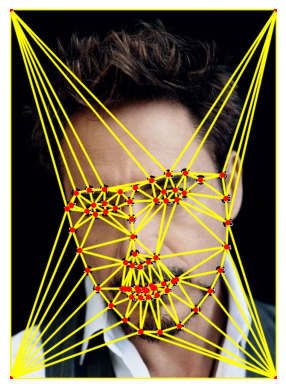

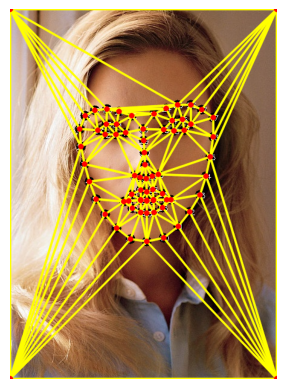

In [70]:
img1, img1Marked, points1 = detectLandmarks(file_paths[0])
img2, img2Marked, points2 = detectLandmarks(file_paths[1])
img3, img3Marked, points3 = detectLandmarks(file_paths[2])

ptsPath1, triPath1 = getTriangles(file_names[0], img1Marked,  points1)
ptsPath2, triPath2 = getTriangles(file_names[1], img2Marked,  points2)
ptsPath3, triPath3 = getTriangles(file_names[2], img3Marked,  points3)

In [71]:
frames = 450
for a in range(frames+1):
    pathname = 'frames/f{:04d}.jpg'.format(a)

    if a < 150:
        imgMorph = morphImage((a/(frames/3)), triPath1, img1, ptsPath1, img2, ptsPath2)
    elif a < 300:
        imgMorph = morphImage(((a-150)/(frames/3)), triPath2, img2, ptsPath2, img3, ptsPath3)
    else:
        imgMorph = morphImage(((a-300)/(frames/3)), triPath3, img3, ptsPath3, img1, ptsPath1)
        
    
    plt.imsave(pathname, imgMorph)
print("Complete!")

Complete!


In [72]:
convertImages2mpeg('./frames/', os.path.join(folder_path, 'transformation.mpg'), 30.0)

OpenCV: FFMPEG: tag 0x3147504d/'MPG1' is not supported with codec id 1 and format 'mpeg / MPEG-1 Systems / MPEG program stream'


In [ ]:
# Empty frames directory
for filename in os.listdir("frames"):
        file_path = os.path.join("./frames", filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path} due to {e}")

# Empty temp directory
for filename in os.listdir("temp"):
        file_path = os.path.join("./temp", filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path} due to {e}")